In [1]:
import numpy as np
from mpmath import mp, mpf, sin, pi, fadd, fsub, fmul, fdiv
import matplotlib.pyplot as plt

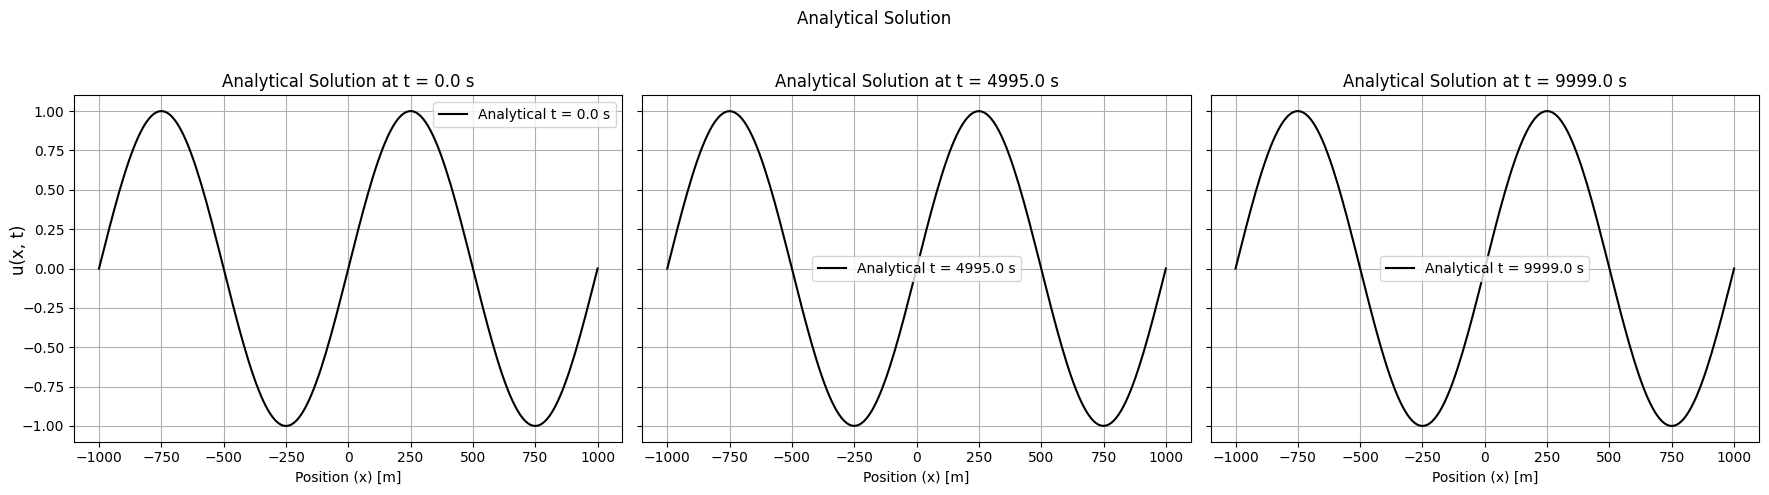

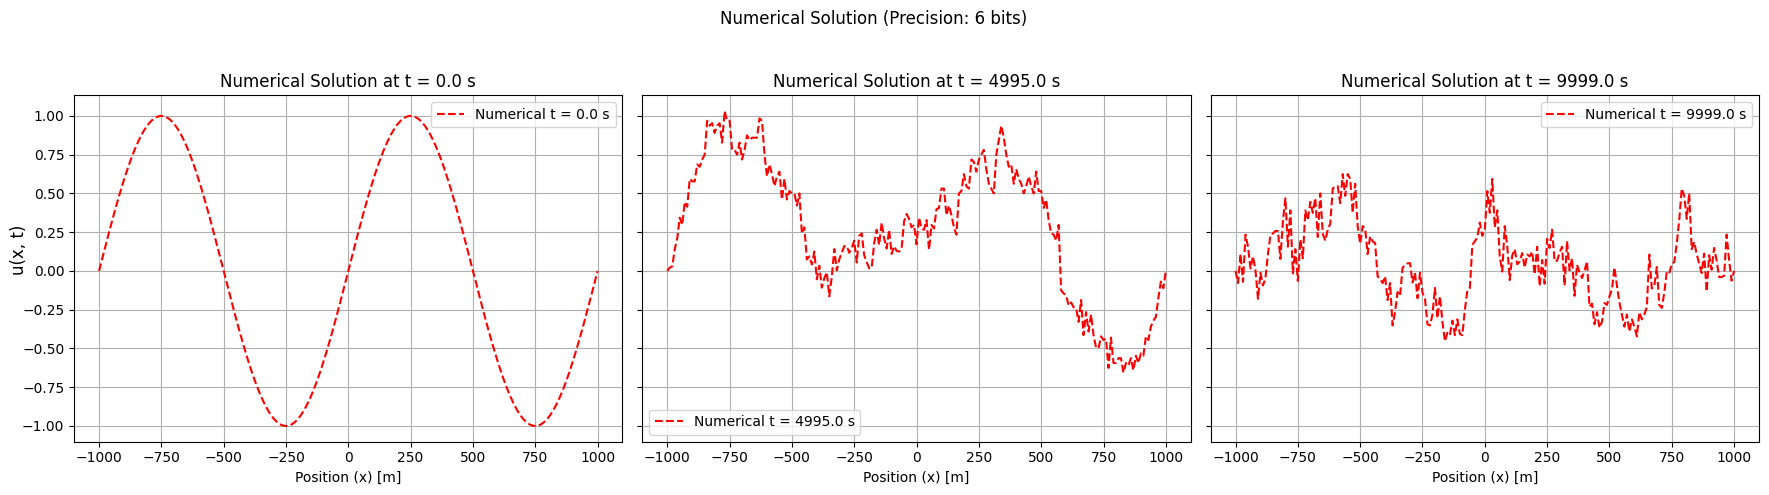

In [27]:
# Set precision
mp.prec = 6

# Constants
L = 1000.0                  # Half-length of the domain in meters (standard float)
c = 1.0                    # Wave speed in m/s (standard float)
N = 201                    # Number of spatial points
dx = (2 * L) / (N - 1)     # Spatial step size for [-L, L] domain
dt = 0.9 * dx / c                # Time step size (CFL condition)
T = 10000.0                 # Total simulation time in seconds (period is T=1000)
x = np.linspace(-L, L, N)  # Spatial grid as a NumPy array

# Total time steps
Nt = int(T / dt) + 1

# Analytical Solution
def analytical_solution(t, x=x, c=c, L=L):
    t_np = float(t)
    return np.cos(2 * np.pi * c * t_np / L) * np.sin(2 * np.pi * x / L)

# Initialize the wave field
u = analytical_solution(0)  # Initial condition u(x, 0) as float
u_prev = u.copy()                          # Initial velocity is zero: u_t(x, 0) = 0
u_next = np.zeros(N, dtype=np.float64)     # Placeholder for the next time step

# Dynamic time indices for plotting and error storage
plot_times = [0, Nt // 2 - 1, Nt - 1]      # Start, middle, and end of the time range
u_num_at_t = {}
errors = []

# Main time evolution loop
for n in range(Nt):
    # Store the results for specific time indices
    if n in plot_times:
        u_num_at_t[n] = u.copy()  # Store the wave profile at the specified time indices

    # Compute the next time step using finite difference
    coeff = mpf(c * dt / dx)          # Cast CFL coefficient to mpf()
    coeff_squared = fmul(coeff, coeff)  # (c * dt / dx) ** 2 as mpf()

    for i in range(1, N - 1):
        # Compute the finite difference term with mpf arithmetic
        term2 = fadd(fsub(mpf(u[i + 1]), fmul(mpf(2), mpf(u[i]))), mpf(u[i - 1]))
        update = fmul(coeff_squared, term2)  # (c * dt / dx) ** 2 * (term2)
        u_next[i] = float(fadd(fsub(fmul(mpf(2), mpf(u[i])), mpf(u_prev[i])), update))  # Cast result back to float

    # Apply boundary conditions (no need for mpf here)
    u_next[0] = 0.0
    u_next[-1] = 0.0

    # Compute error at this time step (if plot_times include the current time step)
    t = n * dt
    if n in plot_times:
        u_analytic = analytical_solution(t)
        errors.append({
            "time": t,
            "error": max(abs(u[i] - u_analytic[i]) for i in range(N))
        })

    # Update arrays for the next time step
    u_prev = u.copy()
    u = u_next.copy()

## Plotting the analytical solution
fig1, axs1 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, idx in enumerate(plot_times):
    t = idx * dt
    # Analytical solution at time t using NumPy variables
    u_analytic = analytical_solution(t)
    axs1[i].plot(x, u_analytic, 'k-', label=f"Analytical t = {float(t)} s")

    # Plot formatting
    axs1[i].set_xlabel("Position (x) [m]")
    axs1[i].set_title(f"Analytical Solution at t = {float(t)} s")
    axs1[i].legend()
    axs1[i].grid(True)

# Set global y-axis label
fig1.supylabel("u(x, t)")
fig1.suptitle("Analytical Solution")
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Plotting the numerical solution
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, idx in enumerate(plot_times):
    t = idx * dt
    # Retrieve the numerical solution for the mapped time index
    u_num = u_num_at_t[idx]
    axs2[i].plot([float(x_i) for x_i in x], [float(u_n) for u_n in u_num], 'r--', label=f"Numerical t = {float(t)} s")

    # Plot formatting
    axs2[i].set_xlabel("Position (x) [m]")
    axs2[i].set_title(f"Numerical Solution at t = {float(t)} s")
    axs2[i].legend()
    axs2[i].grid(True)

# Set global y-axis label
fig2.supylabel("u(x, t)")
fig2.suptitle(f"Numerical Solution (Precision: {mp.prec} bits)")
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


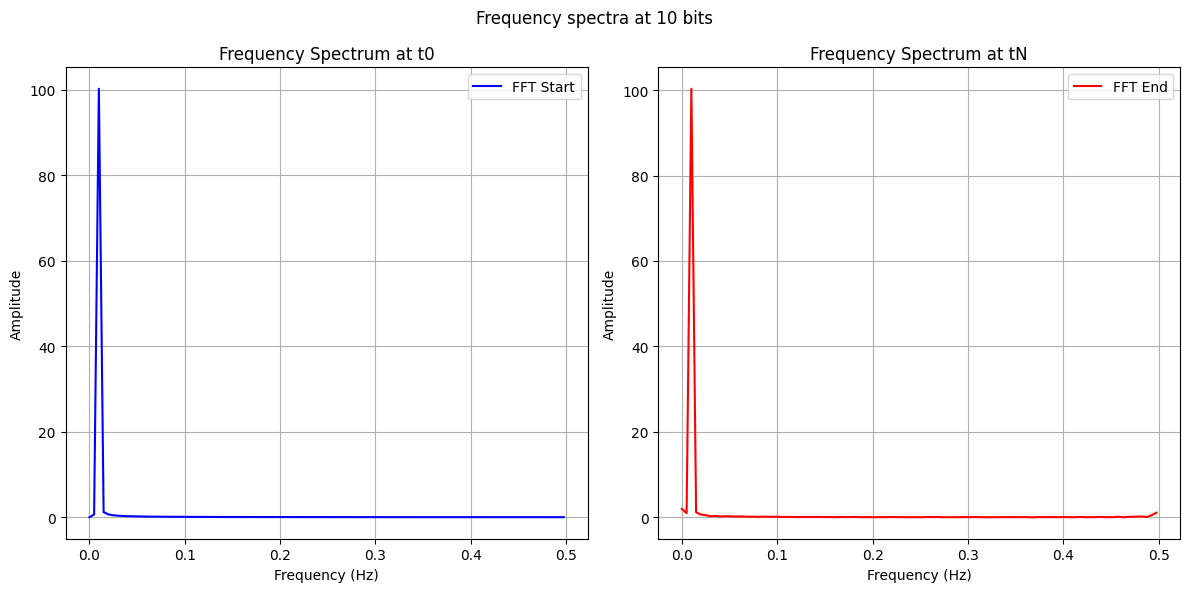

In [4]:
def fft_plot(u_values=u_num_at_t, dt=dt):
    # Extract the wavefield at the start and final time steps
    u_start = u_values[plot_times[0]]
    u_final = u_values[plot_times[2]]
    
    # Perform FFT on the wavefield at the start and end
    Nt_start = len(u_start)
    Nt_final = len(u_final)
    
    # FFT for the start wavefield
    fft_start = np.fft.fft(u_start)
    freqs_start = np.fft.fftfreq(Nt_start, d=dt)
    fft_magnitude_start = np.abs(fft_start)
    
    # FFT for the final wavefield
    fft_final = np.fft.fft(u_final)
    freqs_final = np.fft.fftfreq(Nt_final, d=dt)
    fft_magnitude_final = np.abs(fft_final)
    
    # Filter positive frequencies
    positive_freqs_start = freqs_start[freqs_start >= 0]
    positive_magnitude_start = fft_magnitude_start[freqs_start >= 0]
    
    positive_freqs_final = freqs_final[freqs_final >= 0]
    positive_magnitude_final = fft_magnitude_final[freqs_final >= 0]
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    # Plot the FFT magnitude spectrum of the start wavefield on the first axis
    ax1.plot(positive_freqs_start, positive_magnitude_start, label="FFT Start", color="blue")
    ax1.set_title("Frequency Spectrum at t0")
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Amplitude")
    ax1.legend()
    ax1.grid(True)
    
    # Plot the FFT magnitude spectrum of the final wavefield on the second axis
    ax2.plot(positive_freqs_final, positive_magnitude_final, label="FFT End", color="red")
    ax2.set_title("Frequency Spectrum at tN")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Amplitude")
    ax2.legend()
    ax2.grid(True)
    
    fig.suptitle(f'Frequency spectra at {mp.prec} bits')
    # Adjust layout for better appearance
    plt.tight_layout()
    
    # Show the plots
    plt.show()

fft_plot()

In [5]:
an_sol = analytical_solution(plot_times[1])
num_sol = u_num_at_t[plot_times[1]]
error = np.max(np.abs(an_sol - num_sol))
error

0.016988349302905714